In [226]:
import os, io
from google.cloud import vision
from google.cloud.vision_v1 import types
from google.cloud import translate_v2 as translate
import pandas as pd
import cv2
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from enum import Enum
from termcolor import colored
import goslate
import time
import uuid
import statistics
from itertools import groupby
%matplotlib inline
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'Demz_vision_API_token.json'


In [221]:
## Instantiates the vision and translation clients
vision_client = vision.ImageAnnotatorClient()
translate_client = translate.Client()

In [222]:
# Path to the police report
# export_certificate = 'Test Documents/Test Images/japan_export_certificate.jpg'

japan = 'japanese.jpg'
FOLDER_PATH = 'C:\\Users\\USER\\Desktop\\NEW_DEMZ\\OCR\\OCR_Works\\Google\\japanese\\images'

image = japan

with io.open(os.path.join(FOLDER_PATH, image), 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content) # Reading the Image Content

police_response = vision_client.document_text_detection(
    image=content_image,
    image_context={"language_hints": 'ja'},  # Bengali
)

police_texts = police_response.text_annotations # Text Response

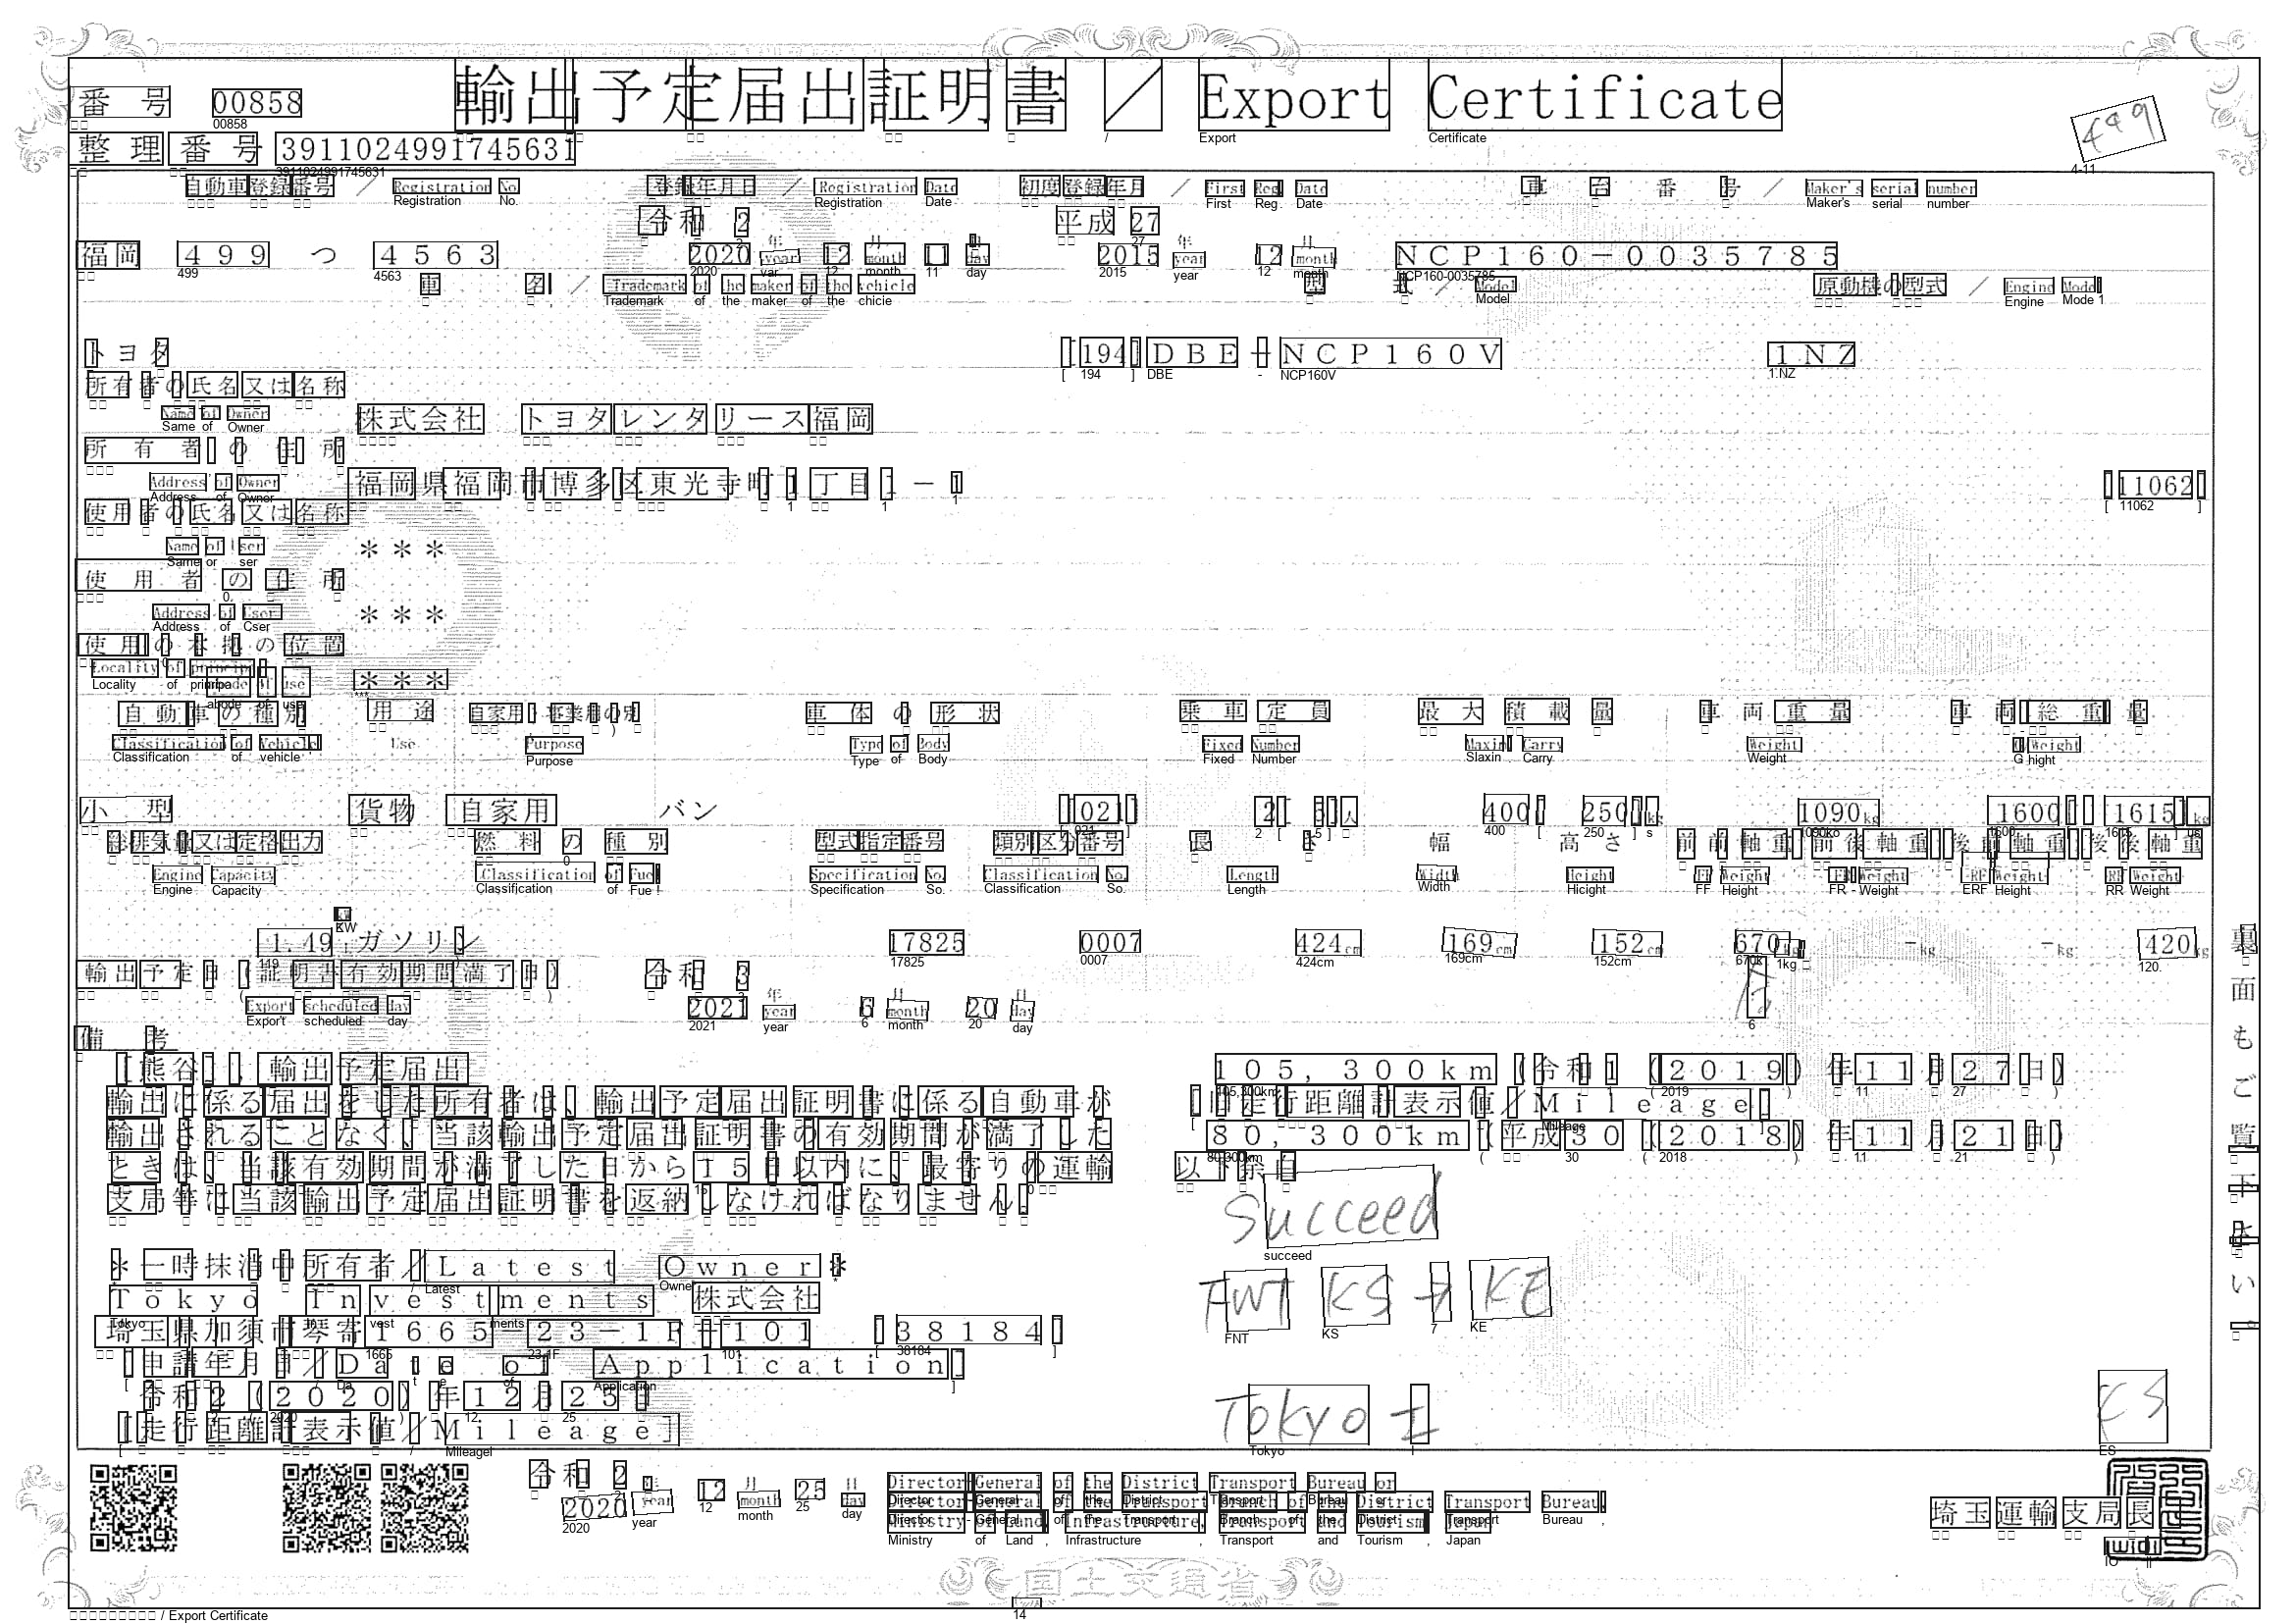

In [94]:
def draw_boxes(image, bounds, color,width=2):
    """This functionality draws bounding box on the detected texts and around the faces if any"""
    image = Image.open(image)

    draw = ImageDraw.Draw(image)
    for text in bounds:
        draw.line([
            text.bounding_poly.vertices[0].x, text.bounding_poly.vertices[0].y, # left
            text.bounding_poly.vertices[1].x, text.bounding_poly.vertices[1].y, # top
            text.bounding_poly.vertices[2].x, text.bounding_poly.vertices[2].y, # right
            text.bounding_poly.vertices[3].x, text.bounding_poly.vertices[3].y, # bootom
            text.bounding_poly.vertices[0].x, text.bounding_poly.vertices[0].y],fill=color, width=width)
        txt=text.description
        size = 13
        font=ImageFont.truetype("fonts/arial.ttf",size)
        
        draw.text((text.bounding_poly.vertices[0].x, text.bounding_poly.vertices[3].y), txt, font=font, fill="#000")
    
    return image

draw_boxes(os.path.join(FOLDER_PATH, image),police_texts, 'blue')


# Phase 1:   Parse rearrange the Documents(line by line)

In [165]:
# rearrange the Response using the bbox values
items = []
lines = {}

for text in police_response.text_annotations[1:]:
    left_x_axis = text.bounding_poly.vertices[0].x # top left
    left_y_axis = text.bounding_poly.vertices[0].y # top left
    top_x_axis = text.bounding_poly.vertices[1].x # top
    top_y_axis = text.bounding_poly.vertices[1].y # top
    right_x_axis = text.bounding_poly.vertices[2].x # right
    right_y_axis = text.bounding_poly.vertices[2].y # right
    bottom_x_axis = text.bounding_poly.vertices[3].x # bottom
    bottom_y_axis = text.bounding_poly.vertices[3].y # bottom
    
    if left_y_axis not in lines:
        lines[left_y_axis] = [(left_y_axis, bottom_y_axis), []]
    for s_top_y_axis, s_item in lines.items():
        if left_y_axis < s_item[0][1]:
            face_vertices = (['({0},{1})'.format(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices])
            lines[s_top_y_axis][1].append(([left_x_axis, bottom_y_axis, top_x_axis, (face_vertices)], text.description))
            break
for _, item in lines.items():
    if item[1]:
        words = sorted(item[1], key=lambda t: t[0])
        items.append((item[0], ' '.join([word for _, word in words]), words))

# print(items)
for i in items:
    print(i)
    print('')

((58, 133), '番号 00858 輸出 予定 届出 証明 書 / Export Certificate 4-11', [([71, 120, 172, ['(71,88)', '(172,87)', '(172,119)', '(71,120)']], '番号'), ([217, 119, 306, ['(217,90)', '(306,90)', '(306,119)', '(217,119)']], '00858'), ([464, 133, 583, ['(464,58)', '(583,58)', '(583,133)', '(464,133)']], '輸出'), ([576, 133, 705, ['(576,58)', '(705,58)', '(705,133)', '(576,133)']], '予定'), ([699, 133, 879, ['(699,58)', '(879,58)', '(879,133)', '(699,133)']], '届出'), ([901, 133, 1006, ['(901,58)', '(1006,58)', '(1006,133)', '(901,133)']], '証明'), ([1026, 133, 1085, ['(1026,58)', '(1085,58)', '(1085,133)', '(1026,133)']], '書'), ([1126, 133, 1183, ['(1126,58)', '(1183,58)', '(1183,133)', '(1126,133)']], '/'), ([1222, 133, 1415, ['(1222,58)', '(1415,58)', '(1415,133)', '(1222,133)']], 'Export'), ([1456, 133, 1815, ['(1456,58)', '(1815,58)', '(1815,133)', '(1456,133)']], 'Certificate'), ([2111, 165, 2193, ['(2111,119)', '(2193,97)', '(2206,143)', '(2124,165)']], '4-11')])

((134, 168), '整理 番号 3911024991745631', 

In [166]:
# Find the most common space
def find_common_space(items):
    spaces = []
    for i,k in enumerate(items):
        try:
            calculated_space = items[i][2][0][0][1] - items[i -1][2][0][0][1]
            spaces.append(calculated_space)
        except:
            ...
        
    common_space = abs(statistics.median(spaces))
    
    return common_space
    
print(find_common_space(items))
# print(len(items))

33


In [167]:
# Split the content based on horizontal space
new_content = []

most_common_space = find_common_space(items)
print(most_common_space)

len_content = len(items) / 5.5

for i,k in enumerate(items):
    try:
        if abs(items[i][2][0][0][1] - items[i -1][2][0][0][1]) >= most_common_space -len_content:
            new_content.append([])
            new_content.append(items[i][2])
        else:
            new_content.append(items[i][2])
    except:
        new_content.append(items[i][2])

33


In [168]:
for i in range(len(new_content)):
    print(new_content[i])
    print('')

[]

[([71, 120, 172, ['(71,88)', '(172,87)', '(172,119)', '(71,120)']], '番号'), ([217, 119, 306, ['(217,90)', '(306,90)', '(306,119)', '(217,119)']], '00858'), ([464, 133, 583, ['(464,58)', '(583,58)', '(583,133)', '(464,133)']], '輸出'), ([576, 133, 705, ['(576,58)', '(705,58)', '(705,133)', '(576,133)']], '予定'), ([699, 133, 879, ['(699,58)', '(879,58)', '(879,133)', '(699,133)']], '届出'), ([901, 133, 1006, ['(901,58)', '(1006,58)', '(1006,133)', '(901,133)']], '証明'), ([1026, 133, 1085, ['(1026,58)', '(1085,58)', '(1085,133)', '(1026,133)']], '書'), ([1126, 133, 1183, ['(1126,58)', '(1183,58)', '(1183,133)', '(1126,133)']], '/'), ([1222, 133, 1415, ['(1222,58)', '(1415,58)', '(1415,133)', '(1222,133)']], 'Export'), ([1456, 133, 1815, ['(1456,58)', '(1815,58)', '(1815,133)', '(1456,133)']], 'Certificate'), ([2111, 165, 2193, ['(2111,119)', '(2193,97)', '(2206,143)', '(2124,165)']], '4-11')]

[]

[([70, 168, 165, ['(70,134)', '(165,134)', '(165,168)', '(70,168)']], '整理'), ([172, 168, 261, ['

In [169]:
# group the contents based on horizontal space
new_content = [list(l) for i, l in groupby(new_content, bool) if i]

# join list that the length is greater than one
for i in range(len(new_content)):
    if len(new_content[i]) > 1:
        new_content[i] = sum(new_content[i], [])
        new_content[i] = [new_content[i]]
    else:
        new_content[i] = new_content[i]


In [170]:
# find common width of white space on the document
def find_common_diff(content):
    diffs = []
    for i,j in enumerate(new_content):
        for u,t in enumerate(new_content[i][0]):
            try:
                difference = abs(new_content[i][0][u][0][2] - new_content[i][0][u-1][0][0])
                diffs.append(difference)
            except:
                ...
    common_diffs = abs(statistics.median(diffs))
    return common_diffs

# print(find_common_diff(new_content))

In [171]:
# find common width of white space on a line
def find_common_diff_in_line(content):
    diffs = []
    for i,j in enumerate(new_content):
        temp_diffs = []
        for u,t in enumerate(new_content[i][0]):
            try:
                difference = abs(new_content[i][0][u][0][0] - new_content[i][0][u-1][0][2])
                temp_diffs.append(difference)
            except:
                ...
        diffs.append(temp_diffs)
    return diffs

# print(find_common_diff_in_line(new_content))

In [172]:
def check_for_max_width(new_content):
    widths = []
    for i,j in enumerate(new_content):
        temp_diffs = []
        for u,t in enumerate(new_content[i][0]):
            try:
                text_width = abs(new_content[i][0][u][0][0] - new_content[i][0][u][0][2])
                temp_diffs.append(text_width)
            except:
                ...
        widths.append(temp_diffs)
    max_width = max(widths)
    return widths
# print(check_for_max_width(new_content))

In [173]:
# split line content based on vertical spacing
contents = []
max_text_width = 600
most_common_diffs = find_common_diff(new_content)

for i,j in enumerate(new_content):
    temp_content = []
    most_common_diffs_in_a_line = abs(statistics.median(find_common_diff_in_line(new_content)[i]))
    text_width = check_for_max_width(new_content)[i]
    max_width = max(text_width)
#     print('')
    for u,t in enumerate(new_content[i][0]):
        try:
            difference = abs(new_content[i][0][u][0][0] - new_content[i][0][u-1][0][2])
            if most_common_diffs >= most_common_diffs_in_a_line and max_width < max_text_width:
                if difference >= most_common_diffs_in_a_line+20: # getting the min width of white space in that line
                    temp_content.append([])
                    temp_content.append(new_content[i][0][u])
                    
                else:
                    temp_content.append(new_content[i][0][u]) 
            elif most_common_diffs >= most_common_diffs_in_a_line and max_width > max_text_width:
   
                if difference > most_common_diffs_in_a_line-15: # getting the min width of white space in that line
                    temp_content.append([])
                    temp_content.append(new_content[i][0][u])
                    
                else:
                    temp_content.append(new_content[i][0][u])
            else:
#                 This bias (20) should increase or decrease depend on document
                if difference > most_common_diffs+20: # getting the most common width of white space in the doc
                    temp_content.append([])
                    temp_content.append(new_content[i][0][u])
                    
                else:
                    temp_content.append(new_content[i][0][u])
        except:
            ...
#     print(temp_content)
    new_temp_content = [list(l) for i, l in groupby(temp_content, bool) if i]
    contents.append(new_temp_content)    
#     contents.append(temp_content)

In [174]:
for i in contents:
    print(i)
    print('')

[[([71, 120, 172, ['(71,88)', '(172,87)', '(172,119)', '(71,120)']], '番号'), ([217, 119, 306, ['(217,90)', '(306,90)', '(306,119)', '(217,119)']], '00858')], [([464, 133, 583, ['(464,58)', '(583,58)', '(583,133)', '(464,133)']], '輸出'), ([576, 133, 705, ['(576,58)', '(705,58)', '(705,133)', '(576,133)']], '予定'), ([699, 133, 879, ['(699,58)', '(879,58)', '(879,133)', '(699,133)']], '届出'), ([901, 133, 1006, ['(901,58)', '(1006,58)', '(1006,133)', '(901,133)']], '証明'), ([1026, 133, 1085, ['(1026,58)', '(1085,58)', '(1085,133)', '(1026,133)']], '書'), ([1126, 133, 1183, ['(1126,58)', '(1183,58)', '(1183,133)', '(1126,133)']], '/'), ([1222, 133, 1415, ['(1222,58)', '(1415,58)', '(1415,133)', '(1222,133)']], 'Export'), ([1456, 133, 1815, ['(1456,58)', '(1815,58)', '(1815,133)', '(1456,133)']], 'Certificate')], [([2111, 165, 2193, ['(2111,119)', '(2193,97)', '(2206,143)', '(2124,165)']], '4-11')]]

[[([70, 168, 165, ['(70,134)', '(165,134)', '(165,168)', '(70,168)']], '整理'), ([172, 168, 261, ['(

# Phase 2: Extract the needed info

In [175]:
# Extract the first 3 contents that the starting position is less than 80 and the bottom position is less than 300 

max_bottom_position = 300
max_start_pos = 80

new_contents = []
for item in range(len(contents)):
    context_in_line = contents[item][0]
    start_position = contents[item][0][0][0][0]
    bottom_position = contents[item][0][0][0][1]
#     print(contents[item][0][0][0][0])
    if start_position < max_start_pos and bottom_position < max_bottom_position:
        new_contents.append(context_in_line)
    else:
        ...
        

In [191]:
for i in new_contents:
    print(i)
    print('')

[([71, 120, 172, ['(71,88)', '(172,87)', '(172,119)', '(71,120)']], '番号'), ([217, 119, 306, ['(217,90)', '(306,90)', '(306,119)', '(217,119)']], '00858')]

[([70, 168, 165, ['(70,134)', '(165,134)', '(165,168)', '(70,168)']], '整理'), ([172, 168, 261, ['(172,134)', '(261,134)', '(261,168)', '(172,168)']], '番号'), ([281, 168, 585, ['(281,134)', '(585,134)', '(585,168)', '(281,168)']], '3911024991745631')]

[([78, 274, 141, ['(78,245)', '(141,245)', '(141,274)', '(78,274)']], '福岡'), ([181, 271, 273, ['(181,245)', '(273,246)', '(273,272)', '(181,271)']], '499'), ([381, 274, 506, ['(381,246)', '(506,245)', '(506,273)', '(381,274)']], '4563')]



In [212]:
# get the bound for croping out the detected text
bounds = []
for i in range(len(new_contents)):
    line_bound = []
    for u in range(len(new_contents[i]) - len(new_contents[i])+1):
        print(new_contents[i][u][1])
        first_top = new_contents[i][u][0][3][0]
#         first_bottom = new_contents[i][u][0][3][1]
        
#         last_top = new_contents[i][u-1][0][3][2]
        last_bottom = new_contents[i][u-1][0][3][2]
        
        bound = [first_top, last_bottom]
        line_bound.append(bound)
    bounds.append(line_bound)
        
for i in bounds:
    print('')
    print(i)

番号
整理
福岡

[['(71,88)', '(306,119)']]

[['(70,134)', '(585,168)']]

[['(78,245)', '(506,273)']]


In [227]:
# Get crop hint
crop_hints_params = vision.CropHintsParams(aspect_ratios=[1.77])
def get_crop_hint(crop_hints):
    """Detect crop hints on a single image and return the first result."""
    with io.open(crop_hints, 'rb') as image_file1:
        content = image_file1.read()

    # content = crop_hints
    image = vision.Image(content=content)
    client = vision_client
    image_context = vision.ImageContext(crop_hints_params=crop_hints_params)

    response = client.crop_hints(image=image, image_context=image_context)
    hints = response.crop_hints_annotation.crop_hints

    # Get bounds for the first crop hint using an aspect ratio of 1.77.
    vertices = hints[0].bounding_poly.vertices

    return vertices

def crop_Text_hint(image_file, TextAnnotations):
    """Crop the image using the hints in the vector list."""
    vects = get_crop_hint(image_file)
    TextAnnotations = TextAnnotations
    try:
        images = []
        for i in range(len(TextAnnotations)):
#             print(TextAnnotations[i][0])
            bound_1 = TextAnnotations[i][0][0]
            bound_2 = TextAnnotations[i][0][1]
            bound_1 = eval(bound_1)
            bound_2 = eval(bound_2)

            im = Image.open(image_file)

            im2 = im.crop([bound_1[0], bound_1[1],
                          bound_2[0] - 1, bound_2[1] - 1])
            unique_id = uuid.uuid4().hex
            output = f'output_{unique_id}.jpg'
            im2.save(output, 'JPEG')
            images.append(im2)
        return images
    except Exception as e:
        print(e)
        print("No Image Detected")
    
face = crop_Text_hint(os.path.join(FOLDER_PATH, image), bounds)
# face

In [224]:
face[0]

# Split the content into sublist(keys and values)

In [108]:
max_diff = 10
main_contents = []
for i,j in enumerate(new_contents):
    temp_content = []
    for u,t in enumerate(new_contents[i]):
        try:
            print(new_contents[i][u][0][0])
            difference = abs(new_contents[i][u][0][0] - new_contents[i][u-1][0][2])
            if difference > max_diff: # getting the most common width of white space in the doc
                temp_content.append([])
                temp_content.append(new_contents[i][u])
            else:
                temp_content.append(new_contents[i][u])
        except:
            temp_content.append(new_contents[i][u])
    new_temp_content = [list(l) for i, l in groupby(temp_content, bool) if i]
    main_contents.append(new_temp_content)

71
217
70
172
281
78
181
381


In [109]:
for i in main_contents:
    print(len(i))
    print('')

2

2

3



In [110]:
rc1_contents = []
max_starting_pos = 100

for i in range(len(main_contents)):
    keys = ''
    values = ''
    for u in range(len(main_contents[i])):
        left_bbox = main_contents[i][u][0][0][0]
        if left_bbox <=max_starting_pos:
            try:
                for j in range(len(main_contents[i][u])):
                    text = main_contents[i][u][j][1]
                    keys += ' '+text
            except:
                ...
        else:
            try:
                for j in range(len(main_contents[i][u])):
                    text = main_contents[i][u][j][1]
                    values += ' '+text
            except:
                ...
    text_translate = translate_client.translate(keys, target_language='en')['translatedText']
    keys = keys + " / " +  text_translate
    rc1_contents.append({keys:values})

In [111]:
for i in range(len(rc1_contents)):
    print(rc1_contents[i])
    print('')

{' 番号 / number': ' 00858'}

{' 整理 番号 / Reference number': ' 3911024991745631'}

{' 福岡 / Fukuoka': ' 499 4563'}

